In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import plotly.graph_objects as go
import os
import plotly.express as px
from scipy.stats import skew,kurtosis

In [106]:
from pathlib import Path
import pandas as pd
data_dir = Path(r'/Users/apple/Desktop/SAPintern/archive/spiral/')
draw_df = pd.DataFrame({'path': list(data_dir.glob('*/*/*.png'))})
draw_df['img_id'] = draw_df['path'].map(lambda x: x.stem)
draw_df['disease'] = draw_df['path'].map(lambda x: x.parent.stem)
draw_df['validation'] = draw_df['path'].map(lambda x: x.parent.parent.stem)
draw_df.sample(5)

,path,img_id,disease,validation
43,/Users/apple/Desktop/SAPintern/archive/spiral/...,V08PE03,parkinson,training
55,/Users/apple/Desktop/SAPintern/archive/spiral/...,V03PE06,parkinson,training
66,/Users/apple/Desktop/SAPintern/archive/spiral/...,V04PE02,parkinson,training
77,/Users/apple/Desktop/SAPintern/archive/spiral/...,V55HE14,healthy,testing
20,/Users/apple/Desktop/SAPintern/archive/spiral/...,V02HE02,healthy,training


## features by Xinjie

In [107]:
def compare_hist(draw_df):
    for i in ["corr","chi","inter","bar","hell","chi_alt"]:
        draw_df[i] = np.nan
    for j in range(len(draw_df)):
        img=cv2.imread(str(draw_df.iloc[j,0]),cv2.IMREAD_GRAYSCALE)
        ret,thresh=cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
        median=cv2.medianBlur(thresh,3)
        G_X = cv2.reduce(thresh, 0 ,cv2.REDUCE_SUM,dtype=cv2.CV_32F)
        G_Y = cv2.reduce(thresh, 1 ,cv2.REDUCE_SUM,dtype=cv2.CV_32F)
        hist1=cv2.calcHist([G_X],[0],None,[65536],[0,65535])
        hist2=cv2.calcHist([G_Y],[0],None,[65536],[0,65535])
        for k in range(4,10):
            draw_df.iloc[j,k]=cv2.compareHist(hist1,hist2,k-4)
    return draw_df

In [108]:
def num_point_projection(draw_df):
    for i in ["mean","median",'range','std','skew','kur']:
        draw_df[i] = np.nan
    
    for j in range(len(draw_df)):
        img=cv2.imread(str(draw_df.iloc[j,0]),cv2.IMREAD_GRAYSCALE)
        ret,thresh=cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
        median=cv2.medianBlur(thresh,3)
        sum_bycolumn=np.sum(median, axis=1) # sum by column
        sum_byrow=np.sum(median, axis=0) # sum by row
        series=np.hstack((sum_byrow,sum_bycolumn))
        series=series.reshape((1,-1))
        
        draw_df.iloc[j,10]=np.mean(series[0])
        draw_df.iloc[j,11]=np.median(series[0])
        draw_df.iloc[j,12]=np.ptp(series[0])
        draw_df.iloc[j,13]=np.std(series[0])
        draw_df.iloc[j,14]=skew(series[0])
        draw_df.iloc[j,15]=kurtosis(series[0])
    return draw_df

In [109]:
def asym_disc(draw_df):
    for i in ['h_dis',"v_dis","asym_disc"]:
        draw_df[i] = np.nan
        
    for j in range(len(draw_df)):
        img=cv2.imread(str(draw_df.iloc[j,0]),cv2.IMREAD_GRAYSCALE)
        ret,thresh=cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
        median=cv2.medianBlur(thresh,3)
        M = cv2.moments(median)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        left_x=np.amin(np.argwhere(median>0),axis=0)[0] # leftmost x
        right_x=np.amax(np.argwhere(median>0),axis=0)[0] # rightmost x
        up_y=np.amin(np.argwhere(median>0),axis=0)[1] # up y
        btm_y=np.amax(np.argwhere(median>0),axis=0)[1] # bottom x

        draw_df.iloc[j,16]=abs((cY-up_y)-(btm_y-cY))/(btm_y-up_y)
        draw_df.iloc[j,17]=abs((cX-left_x)-(right_x-cX))/(right_x-left_x)
        draw_df.iloc[j,18]=draw_df.iloc[j,16]+draw_df.iloc[j,17]
    return draw_df

In [110]:
def generate_features(draw_df):
    draw_df1=compare_hist(draw_df)
    draw_df2=num_point_projection(draw_df1)
    draw_df3=asym_disc(draw_df2)
    return draw_df3

In [111]:
df=generate_features(draw_df)

## feature: brightness + color difference

In [112]:
def get_bright_colordiff(address):
    img=cv2.imread(str(address),cv2.IMREAD_GRAYSCALE)
    return img.mean(),img.std()

## feature: line thickness + line uniformity

In [113]:
## input:  line in a image matrix
## output: m: skeletonized line with i-pixel width nonzero groups, width: the average width in this line area
def skeletonize_line(matrix):
    l = len(matrix)
    m=matrix.copy()
    for i in range(l):
        if i<(l-1) and m[i]>0 and m[i+1]>0: #exclude the last pixel on this vertical line
            m[i]=0
        else:
            continue
    if m.sum()!=0:
        width = matrix.sum()/(m.sum())
    else:
        width = 0
    return m,width

In [114]:
## input: binary image
## output: 1.img2: skeletonized img 2.width_list: a list of 256 size for difference width of different line area
def skeletonize_img_vertical(img):
    img2=img.copy()
    width_list = [0]*img.shape[1]
    for j in range(img.shape[1]):
        img2[:,j],width_list[j]=skeletonize_line(img2[:,j])
    width = [i for i in width_list if i != 0]
    return img2,width

In [115]:
def skeletonize_img_horizontal(img):
    img2=img.copy()
    width_list = [0]*img.shape[0]
    for i in range(img.shape[0]):
        img2[i,:],width_list[i]=skeletonize_line(img2[i,:])
    width = [i for i in width_list if i != 0]
    return img2,width

In [116]:
def get_thick_uniform(address):
    img=cv2.imread(str(address),cv2.IMREAD_GRAYSCALE)
    ret,thresh=cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)

    skeleton_v, width_v = skeletonize_img_vertical(thresh)
    skeleton_h, width_h = skeletonize_img_horizontal(thresh)
    thickness = (thresh.sum()/skeleton_v.sum()+thresh.sum()/skeleton_h.sum())/2
    uniformity = np.array(width_v+width_h).std()
    return thickness, uniformity

## feature: num of circles and resulted mean and std

In [117]:
#input: 1d array 
#output: number of cut points in this line
def count_points(matrix):
    count=0
    for i in range(len(matrix)):
        pixel = matrix[i]
        if i==0 and pixel>0: #the first pixel
            count+=1
        elif pixel>0 and matrix[i-1]==0:
            count+=1
    return count

In [118]:
#input: binary image
#output: horizontal nonzero points, vertical nonzero points
def count_line_cutpoint(img):
    horizon =[0]*img.shape[0]
    vertical =[0]*img.shape[1]
    for i in range(img.shape[0]):
        horizon[i]=count_points(img[i,:])
    for j in range(img.shape[1]):
        vertical[j]=count_points(img[:,j])
    return horizon,vertical

In [119]:
def get_num_circles_mean_std(address):
    img=cv2.imread(str(address),cv2.IMREAD_GRAYSCALE)
    ret,thresh=cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
    median=cv2.medianBlur(thresh,3)
    
    h_ma, v_ma = count_line_cutpoint(median)
    ma=np.hstack((h_ma, v_ma))
    num_circles= max(max(h_ma),max(v_ma))//2
    return num_circles,ma.mean(),ma.std()

In [124]:
def generate_other_features(df):
    draw_df=df.copy()
    draw_df['brightness'] = draw_df['path'].apply(get_bright_colordiff).apply(lambda x:x[0])
    draw_df['colordiff'] = draw_df['path'].apply(get_bright_colordiff).apply(lambda x:x[1])
    draw_df['line_thickness'] = draw_df['path'].apply(get_thick_uniform).apply(lambda x:x[0])
    draw_df['line_diff'] = draw_df['path'].apply(get_thick_uniform).apply(lambda x:x[1])
    draw_df['num_circles'] = draw_df['path'].apply(get_num_circles_mean_std).apply(lambda x:x[0])
    draw_df['cutpoints_mean'] = draw_df['path'].apply(get_num_circles_mean_std).apply(lambda x:x[1])
    draw_df['cutpoints_std'] = draw_df['path'].apply(get_num_circles_mean_std).apply(lambda x:x[2])
    return draw_df

In [ ]:
df_full = generate_other_features(df)

In [ ]:
df_full.to_csv('features_full.csv',index=False)

## modelling

In [7]:
df_model = pd.read_csv('features_full.csv')

In [9]:
df_model.columns

Index(['img_id', 'brightness', 'colordiff', 'line_thickness', 'line_diff',
       'num_circles', 'cutpoints_mean', 'cutpoints_std', 'path', 'disease',
       'validation', 'corr', 'chi', 'inter', 'bar', 'hell', 'chi_alt', 'mean',
       'median', 'range', 'std', 'skew', 'kur', 'h_dis', 'v_dis', 'asym_disc'],
      dtype='object')

### EDA

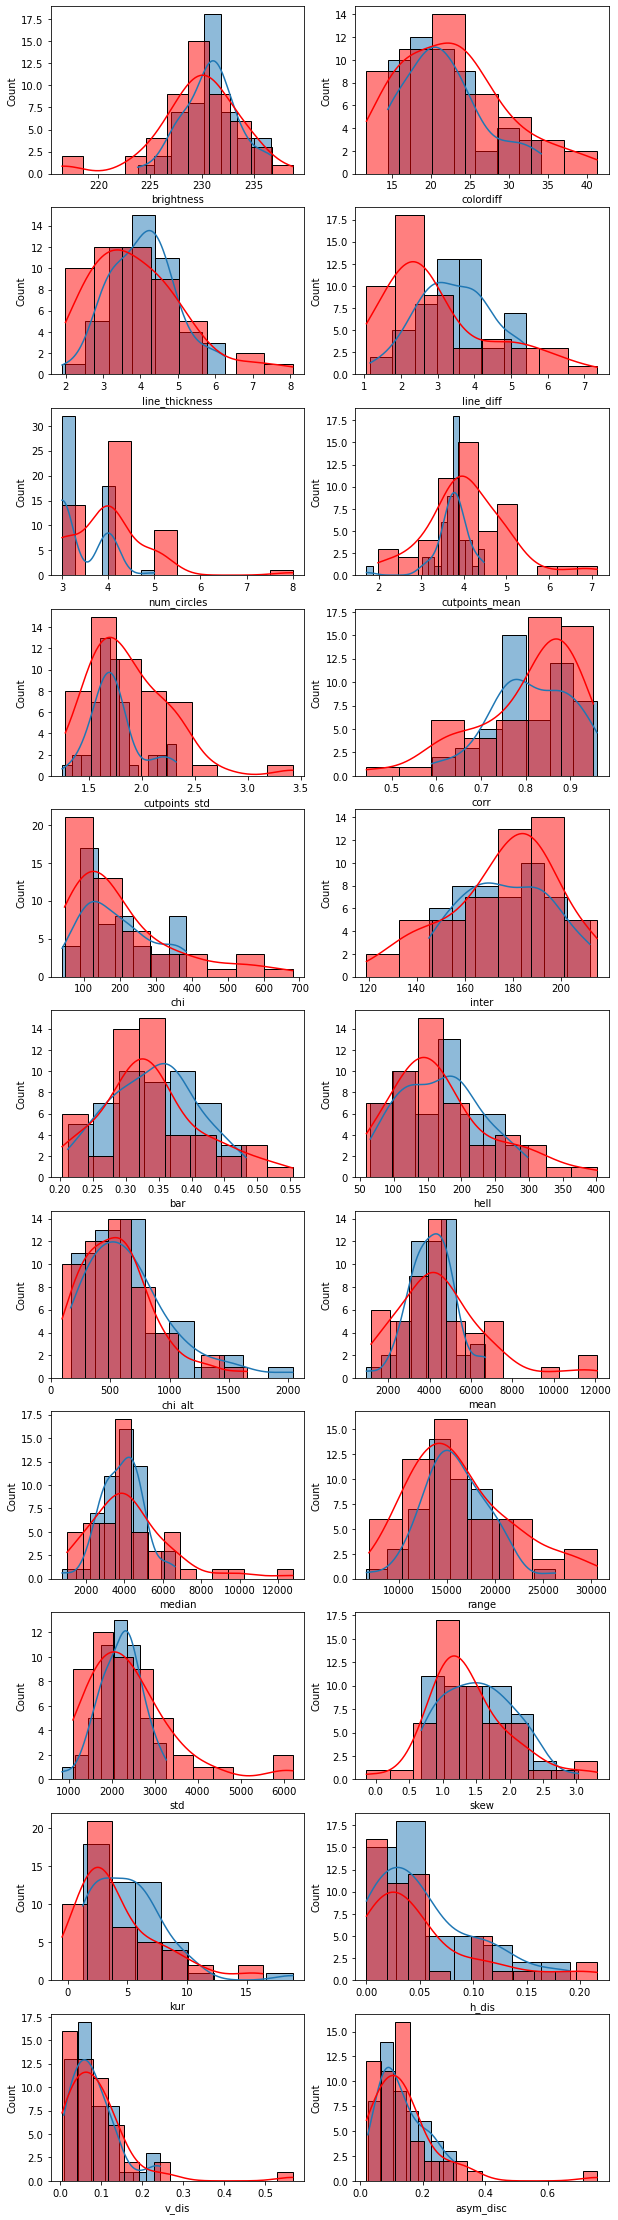

In [91]:
cols=['brightness', 'colordiff', 'line_thickness', 'line_diff',
       'num_circles', 'cutpoints_mean', 'cutpoints_std', 
       'corr', 'chi', 'inter', 'bar', 'hell', 'chi_alt', 'mean',
       'median', 'range', 'std', 'skew', 'kur', 'h_dis', 'v_dis', 'asym_disc']

#plot histo distribution after scaling

fig, axs = plt.subplots(11, 2, figsize=(10,40))

for i in range(11):
    for j in range(2):
        n=i*2+j
        if n<22:
            sns.histplot(df_model[df_model['disease']=='healthy'][cols[n]], kde=True, ax= axs[i,j])
            sns.histplot(df_model[df_model['disease']=='parkinson'][cols[n]], kde=True, color='red',ax= axs[i,j])

### base model

In [72]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import xgboost as xgb
import lightgbm as lgb
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.linear_model import LogisticRegression
X=df_model[cols]
y=df_model['disease'].map(lambda x: x=='parkinson').astype('int')

In [65]:
# function to print result
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.model_selection import cross_val_score
def model_result(model, X_train, y_train):
    precision=cross_val_score(estimator=model,X=X_train,y=y_train,scoring='precision')
    recall=cross_val_score(estimator=model,X=X_train,y=y_train,scoring='recall')
    acc=cross_val_score(estimator=model,X=X_train,y=y_train,scoring='accuracy')
    print("5-fold precision is", precision)
    print("5-fold recall is", recall)
    print("5-fold accuracy is",acc)
    print("mean accuracy is {}, std is {}".format(round(acc.mean(),3),round(acc.std(),3)))

#### xgb

In [66]:
seed=42
model_xgb=xgb.XGBClassifier(random_state=seed)
X=df_model[cols]
model_result(model_xgb,X,y) 

5-fold precision is [0.6        0.85714286 0.58333333 0.875      0.6       ]
5-fold recall is [0.3        0.54545455 0.7        0.7        0.6       ]
5-fold accuracy is [0.57142857 0.71428571 0.6        0.8        0.6       ]
mean accuracy is 0.657, std is 0.087


In [67]:
new_cols=['brightness', 'colordiff', 'line_thickness', 'line_diff',
       'num_circles', 'cutpoints_mean', 'cutpoints_std', 
       'corr', 'chi', 'inter', 'bar', 'hell', 'chi_alt', 'h_dis', 'v_dis', 'asym_disc']
X=df_model[new_cols]
model_result(model_xgb,X,y) 

5-fold precision is [0.8        0.57142857 0.61538462 0.875      0.66666667]
5-fold recall is [0.4        0.36363636 0.8        0.7        0.8       ]
5-fold accuracy is [0.66666667 0.52380952 0.65       0.8        0.7       ]
mean accuracy is 0.668, std is 0.089


#### lightgbm

In [68]:
model_lgb=lgb.LGBMClassifier(random_state=seed)
X=df_model[cols]
model_result(model_lgb,X,y) 

5-fold precision is [0.5        0.7        0.64285714 0.8        0.6       ]
5-fold recall is [0.3        0.63636364 0.9        0.8        0.6       ]
5-fold accuracy is [0.52380952 0.66666667 0.7        0.8        0.6       ]
mean accuracy is 0.658, std is 0.093


In [69]:
X=df_model[new_cols]
model_result(model_lgb,X,y) 

5-fold precision is [0.6        0.7        0.69230769 0.8        0.63636364]
5-fold recall is [0.3        0.63636364 0.9        0.8        0.7       ]
5-fold accuracy is [0.57142857 0.66666667 0.75       0.8        0.65      ]
mean accuracy is 0.688, std is 0.08


comment: it seems feature selection is needed

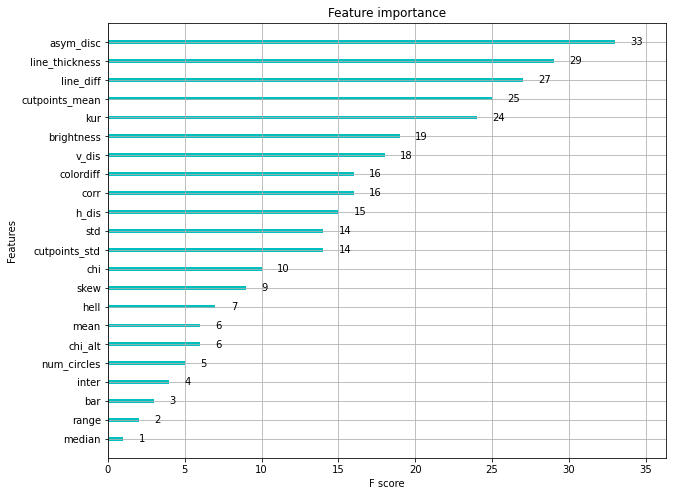

In [89]:
from xgboost import plot_importance
X=df_model[cols]
model_xgb.fit(X,y)
plt.rcParams["figure.figsize"] = (10, 8)
plot_importance(model_xgb,color='c')
plt.show()

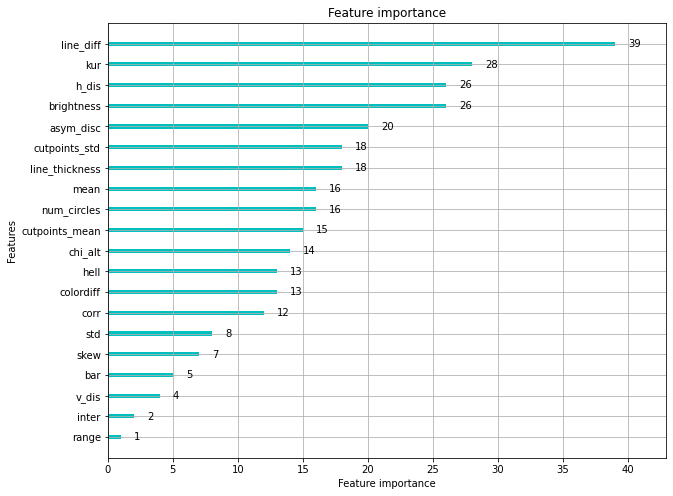

In [90]:
from lightgbm import plot_importance
X=df_model[cols]
model_lgb.fit(X,y)
plt.rcParams["figure.figsize"] = (10, 8)
plot_importance(model_lgb,color='c')
plt.show()

In [98]:
important_cols=['brightness', 'colordiff', 'line_thickness', 'line_diff',
                'num_circles', 'cutpoints_mean', 'cutpoints_std', 'corr',  'hell', 
                'h_dis', 'v_dis', 'asym_disc']
X=df_model[important_cols]
model_result(model_lgb,X,y) 
print('-----------------------------------------------------------------------------')
model_result(model_xgb,X,y) 

5-fold precision is [0.71428571 0.71428571 0.69230769 0.8        0.63636364]
5-fold recall is [0.5        0.45454545 0.9        0.8        0.7       ]
5-fold accuracy is [0.66666667 0.61904762 0.75       0.8        0.65      ]
mean accuracy is 0.697, std is 0.067
-----------------------------------------------------------------------------
5-fold precision is [0.8        0.625      0.61538462 0.72727273 0.69230769]
5-fold recall is [0.4        0.45454545 0.8        0.8        0.9       ]
5-fold accuracy is [0.66666667 0.57142857 0.65       0.75       0.75      ]
mean accuracy is 0.678, std is 0.067


## fine-tune

In [117]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
import lightgbm as lgb
import time
seed=42
start = time.time()

X=df_model[cols]

LGBM=lgb.LGBMClassifier(random_state=seed,learning_rate=0.1)

pipe_lgb = Pipeline([('preprocessing', MinMaxScaler()), 
                     ('oversampling', None),
                     ('classifier',LGBM)])

param_lgb =  [{'preprocessing': [MinMaxScaler(),StandardScaler()],
               'oversampling':[None, SMOTE(random_state=seed),SMOTEENN(random_state=seed)],
               'classifier':[LGBM],
               'classifier__num_leaves':[30, 60, 90],
               'classifier__reg_alpha':[0.1,0.2,0.3,0.4,0.5],
               'classifier__max_depth':[5,10,15]}]

grid_lgb = GridSearchCV(estimator=pipe_lgb,
                        param_grid=param_lgb,
                        cv=5,
                        n_jobs=5,
                        scoring='accuracy')

grid_lgb.fit(X[important_cols],y)


print(f"Time taken to run: {round((time.time() - start)/60,1)} minutes")
print("Best AUC:", round(grid_lgb.best_score_,3))
print("Best parameters:", grid_lgb.best_params_)

Time taken to run: 0.1 minutes
Best AUC: 0.727
Best parameters: {'classifier': LGBMClassifier(max_depth=5, num_leaves=30, random_state=42, reg_alpha=0.3), 'classifier__max_depth': 5, 'classifier__num_leaves': 30, 'classifier__reg_alpha': 0.3, 'oversampling': SMOTE(random_state=42), 'preprocessing': StandardScaler()}


In [118]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
import lightgbm as lgb
import time
seed=42
start = time.time()

X=df_model[cols]

xgb1=xgb.XGBClassifier(random_state=seed,learning_rate=0.1)

pipe_xgb = Pipeline([('preprocessing', MinMaxScaler()), 
                     ('oversampling', None),
                     ('classifier',xgb1)])

param_xgb =  [{'preprocessing': [MinMaxScaler(),StandardScaler()],
               'oversampling':[None, SMOTE(random_state=seed),SMOTEENN(random_state=seed)],
               'classifier':[xgb1],
               'classifier__eta':[0.05,0.1,0.2,0.3],
               'classifier__n_estimators':[50,100,200],
               'classifier__max_depth':[5,10,15]}]

grid_xgb = GridSearchCV(estimator=pipe_xgb,
                        param_grid=param_xgb,
                        cv=5,
                        n_jobs=5,
                        scoring='accuracy')

grid_xgb.fit(X[important_cols],y)


print(f"Time taken to run: {round((time.time() - start)/60,1)} minutes")
print("Best AUC:", round(grid_xgb.best_score_,3))
print("Best parameters:", grid_xgb.best_params_)

Time taken to run: 0.1 minutes
Best AUC: 0.716
Best parameters: {'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eta=0.05,
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=42,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=None, tree_method=None, validate_parameters=None,
              verbosity=None), 'classifier__eta': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'oversampling': None, 'preprocessing': MinMaxScaler()}


## see stacking result

### level 1: xgb

In [119]:
%%time
# stacking model building
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
best_lgb=grid_lgb.best_estimator_
best_xgb=grid_xgb.best_estimator_

# get a stacking ensemble of models
def get_model():
    # define the level-0 base models with tuned paramters
    level0 = []
    level0.append(('lgb', best_lgb))
    level0.append(('rf', best_xgb))
    # define level-1 meta learner model
    level1 = xgb.XGBClassifier(random_state=seed)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1)
    return model

# get the models to evaluate
stacking_model = get_model()

CPU times: user 46 µs, sys: 0 ns, total: 46 µs
Wall time: 49.1 µs


In [120]:
start = time.time()


param_stack=  [{'final_estimator__max_depth':[5,7,10,15],
                'final_estimator__n_estimators':[50,100],
                'final_estimator__eta':[0.1,0.2,0.3]}]

grid_stack = GridSearchCV(estimator=stacking_model,
                          param_grid=param_stack,
                          cv=5,
                          n_jobs=5,
                          scoring='roc_auc')

grid_stack.fit(X[important_cols],y)

print(f"Time taken to run: {round((time.time() - start)/60,1)} minutes")
print("Best AUC:", round(grid_stack.best_score_,3))
print("Best parameters:", grid_stack.best_params_)

Time taken to run: 0.1 minutes
Best AUC: 0.7
Best parameters: {'final_estimator__eta': 0.1, 'final_estimator__max_depth': 5, 'final_estimator__n_estimators': 100}


### level 1: lgb

In [121]:
%%time
# stacking model building
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
best_lgb=grid_lgb.best_estimator_
best_xgb=grid_xgb.best_estimator_

# get a stacking ensemble of models
def get_model():
    # define the level-0 base models with tuned paramters
    level0 = []
    level0.append(('lgb', best_lgb))
    level0.append(('rf', best_xgb))
    # define level-1 meta learner model
    level1 = lgb.LGBMClassifier(random_state=seed)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1)
    return model

# get the models to evaluate
stacking_model = get_model()

CPU times: user 76 µs, sys: 11 µs, total: 87 µs
Wall time: 122 µs


In [122]:
start = time.time()


param_stack=  [{'final_estimator__num_leaves':[30, 60, 90],
                'final_estimator__reg_alpha':[0.1,0.2,0.3,0.4,0.5],
                'final_estimator__max_depth':[5,10,15]}]

grid_stack = GridSearchCV(estimator=stacking_model,
                          param_grid=param_stack,
                          cv=5,
                          n_jobs=5,
                          scoring='roc_auc')

grid_stack.fit(X[important_cols],y)

print(f"Time taken to run: {round((time.time() - start)/60,1)} minutes")
print("Best AUC:", round(grid_stack.best_score_,3))
print("Best parameters:", grid_stack.best_params_)

Time taken to run: 0.2 minutes
Best AUC: 0.704
Best parameters: {'final_estimator__max_depth': 5, 'final_estimator__num_leaves': 30, 'final_estimator__reg_alpha': 0.5}


## model with forward selection

In [126]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
start = time.time()

X=df_model[cols]

LGBM=lgb.LGBMClassifier(random_state=seed,learning_rate=0.1)

sfs = SFS(estimator=LGBM, 
          k_features=10,
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=5)



pipe_lgb = Pipeline([('preprocessing', MinMaxScaler()), 
                     ('oversampling', None),
                     ('sfs', sfs),
                     ('classifier',LGBM)])

params_lgb = [ 
  {
   'preprocessing': [MinMaxScaler(),StandardScaler()],
   'oversampling':[None, SMOTE(random_state=seed),SMOTEENN(random_state=seed)],
   'sfs__k_features': [10,12,15],
   'sfs__estimator__num_leaves':[30, 60, 90],
   'sfs__estimator__reg_alpha':[0.1,0.2,0.3,0.4,0.5],
   'sfs__estimator__max_depth':[5,10,15]
  }
]


grid_lgb = GridSearchCV(estimator=pipe_lgb,
                        param_grid=param_lgb,
                        cv=5,
                        n_jobs=5,
                        scoring='accuracy')

grid_lgb.fit(X,y)


print(f"Time taken to run: {round((time.time() - start)/60,1)} minutes")
print("Best AUC:", round(grid_lgb.best_score_,3))
print("Best parameters:", grid_lgb.best_params_)

Time taken to run: 40.7 minutes
Best AUC: 0.698
Best parameters: {'classifier': LGBMClassifier(max_depth=5, num_leaves=30, random_state=42, reg_alpha=0.1), 'classifier__max_depth': 5, 'classifier__num_leaves': 30, 'classifier__reg_alpha': 0.1, 'oversampling': SMOTE(random_state=42), 'preprocessing': StandardScaler()}


In [127]:
start = time.time()

X=df_model[cols]

xgb1=xgb.XGBClassifier(random_state=seed,learning_rate=0.1)

sfs = SFS(estimator=xgb1, 
          k_features=10,
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=5)



pipe_xgb = Pipeline([('preprocessing', MinMaxScaler()), 
                     ('oversampling', None),
                     ('sfs', sfs),
                     ('classifier',xgb1)])

params_xgb = [ 
  {
   'preprocessing': [MinMaxScaler(),StandardScaler()],
   'oversampling':[None, SMOTE(random_state=seed),SMOTEENN(random_state=seed)],
   'sfs__k_features': [10,12,15],
   'sfs__estimator__n_estimators':[50,100],
   'sfs__estimator__eta':[0.1,0.2,0.3],
   'sfs__estimator__max_depth':[5,10,15]
  }
]

grid_xgb = GridSearchCV(estimator=pipe_xgb,
                        param_grid=param_xgb,
                        cv=5,
                        n_jobs=5,
                        scoring='accuracy')

grid_xgb.fit(X,y)


print(f"Time taken to run: {round((time.time() - start)/60,1)} minutes")
print("Best AUC:", round(grid_xgb.best_score_,3))
print("Best parameters:", grid_xgb.best_params_)

Time taken to run: 39.7 minutes
Best AUC: 0.667
Best parameters: {'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eta=0.05,
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1,
              max_delta_step=None, max_depth=10, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=None, tree_method=None, validate_parameters=None,
              verbosity=None), 'classifier__eta': 0.05, 'classifier__max_depth': 10, 'classifier__n_estimators': 200, 'oversampling': SMOTE(random_state=42), 'preprocessing': MinMaxScaler()}
